## 30-Day Price Direction Target

In [12]:
import numpy as np
import pandas as pd

train = pd.read_csv(r'D:\Stock_trend_project\data\raw\train.csv')

train['Date'] = pd.to_datetime(train['Date'])
train = train.sort_values(['Ticker', 'Date'])

horizon = 30

def add_target_per_ticker(g):
    g = g.sort_values('Date')
    g['Close_t_plus_30'] = g['Close'].shift(-horizon)
    g['target_up_30d'] = (g['Close_t_plus_30'] > g['Close']).astype(int)
    return g.dropna(subset=['Close_t_plus_30'])

train_with_target = (
    train
    .groupby('Ticker', group_keys=False)
    .apply(add_target_per_ticker)
    .reset_index(drop=True)
)


train_with_target


C:\Users\LENONO\AppData\Local\Temp\ipykernel_2492\3210477301.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(add_target_per_ticker)


,Ticker,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_t_plus_30,target_up_30d
0,ticker_1,1962-01-02,0.000000,0.265828,0.261788,0.261788,25600.0,0.0,0.0,0.254992,0
1,ticker_1,1962-01-03,0.000000,0.263808,0.261788,0.261788,28800.0,0.0,0.0,0.258663,0
2,ticker_1,1962-01-04,0.000000,0.263404,0.260980,0.260980,21600.0,0.0,0.0,0.261927,1
3,ticker_1,1962-01-05,0.000000,0.259364,0.255324,0.255324,46400.0,0.0,0.0,0.258256,1
4,ticker_1,1962-01-08,0.000000,0.259364,0.255728,0.256536,29600.0,0.0,0.0,0.259071,1
...,...,...,...,...,...,...,...,...,...,...,...
20883517,ticker_999,2024-08-05,77.559998,79.220001,76.980003,79.099998,777200.0,0.0,0.0,87.709999,1
20883518,ticker_999,2024-08-06,79.300003,81.349998,78.949997,80.949997,1572600.0,0.0,0.0,86.870003,1
20883519,ticker_999,2024-08-07,82.349998,82.470001,79.820000,80.209999,741700.0,0.0,0.0,88.800003,1
20883520,ticker_999,2024-08-08,80.669998,81.389999,80.610001,81.309998,1008600.0,0.0,0.0,89.910004,1


- Compute class counts of the target `target_up_30d` (0 = Fall, 1 = Rise) with `value_counts`.
- Compute class percentages with `value_counts(normalize=True) * 100` and print the share of each class.
- Plot a `countplot` of `target_up_30d` to visualize how many samples belong to class 0 vs class 1 (overall class balance).


target_up_30d
1    11266213
0     9617309
Name: count, dtype: int64
target_up_30d
1    53.947859
0    46.052141
Name: proportion, dtype: float64
نسبة Fall (0): 46.05%
نسبة Rise (1): 53.95%


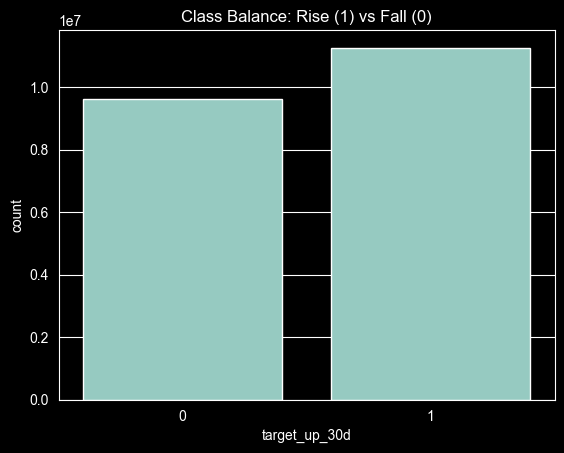

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
class_counts = train_with_target['target_up_30d'].value_counts()
print(class_counts)

class_pct = train_with_target['target_up_30d'].value_counts(normalize=True) * 100
print(class_pct)

print(f"نسبة Fall (0): {class_pct.get(0, 0):.2f}%")
print(f"نسبة Rise (1): {class_pct.get(1, 0):.2f}%")

sns.countplot(x='target_up_30d', data=train_with_target)
plt.title("Class Balance: Rise (1) vs Fall (0)")
plt.show()



In [22]:
per_ticker_balance = (
    train_with_target
    .groupby('Ticker')['target_up_30d']
    .value_counts(normalize=True)
    .unstack(fill_value=0) * 100
)

per_ticker_balance


target_up_30d,0,1
Ticker,,
ticker_1,40.675170,59.324830
ticker_10,39.558348,60.441652
ticker_100,41.639673,58.360327
ticker_1000,49.979992,50.020008
ticker_1001,45.277481,54.722519
...,...,...
ticker_995,57.400000,42.600000
ticker_996,43.173333,56.826667
ticker_997,37.858381,62.141619


### Class balance by year (Rise vs Fall)

- The plot shows, for each calendar year, the percentage of days labeled as `Rise (1)` and `Fall (0)` in `target_up_30d`.
- Most years stay roughly in the 40–60% range for both classes, with no long periods where one class completely dominates.
- This indicates that the target label is **reasonably stable and not strongly imbalanced across years**, so the model can learn from the full historical period without dropping specific years due to extreme class imbalance.


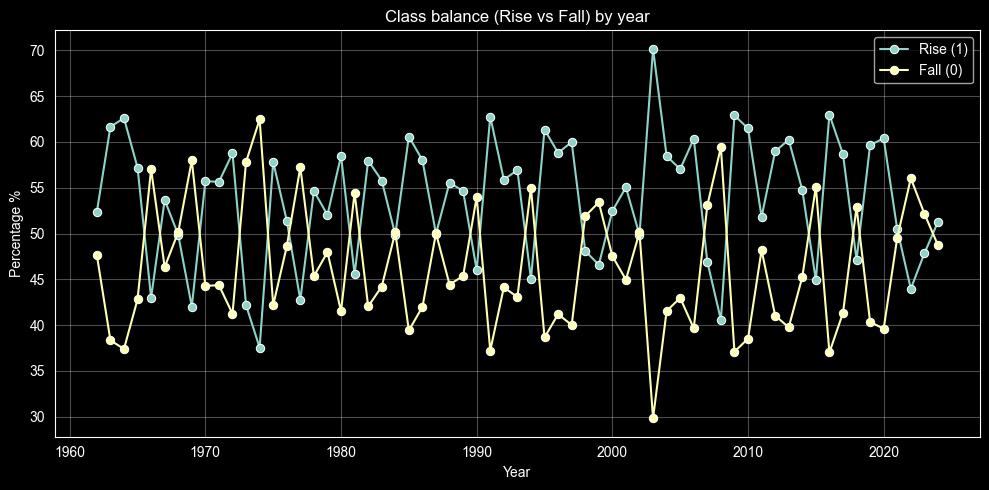

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

per_year_balance = (
    train_with_target
    .groupby('year')['target_up_30d']
    .value_counts(normalize=True)
    .unstack(fill_value=0) * 100
)
per_year_balance = per_year_balance.rename(columns={0: 'pct_fall', 1: 'pct_rise'})

plt.figure(figsize=(10, 5))
sns.lineplot(data=per_year_balance, x=per_year_balance.index, y='pct_rise', marker='o', label='Rise (1)')
sns.lineplot(data=per_year_balance, x=per_year_balance.index, y='pct_fall', marker='o', label='Fall (0)')

plt.xlabel('Year')
plt.ylabel('Percentage %')
plt.title('Class balance (Rise vs Fall) by year')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
